In [103]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 10.1

In [2]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1

#### Code 10.2

In [3]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:01<00:00, 1158.85it/s]


In [28]:
df_10_1 = pm.summary(trace_10_1, alpha=.11)
df_10_1.round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.32,0.09,0.00,0.16,0.46,1735.0,1.0
bp,0.06,9.97,0.21,-15.99,15.54,2000.0,1.0


#### Code 10.3

In [8]:
logistic(df_10_1.iloc[:,3:5]).round(5)

,hpd_5.5,hpd_94.5
a,0.54033,0.61261
bp,0.00000,1.00000


#### Code 10.4

In [9]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 504.53it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:04<00:00, 492.58it/s]


#### Code 10.5

In [45]:
comp_df = pm.compare(traces=[trace_10_1, trace_10_2, trace_10_3],
                     models=[model_10_1, model_10_2, model_10_3],
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.1', 'm10.2', 'm10.3'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
m10.2,680.78,2.14,0,0.68,9.33,0,0
m10.3,682.41,3.03,1.63,0.3,9.36,0.75,0
m10.1,688.07,1.06,7.28,0.02,7.07,6.19,0


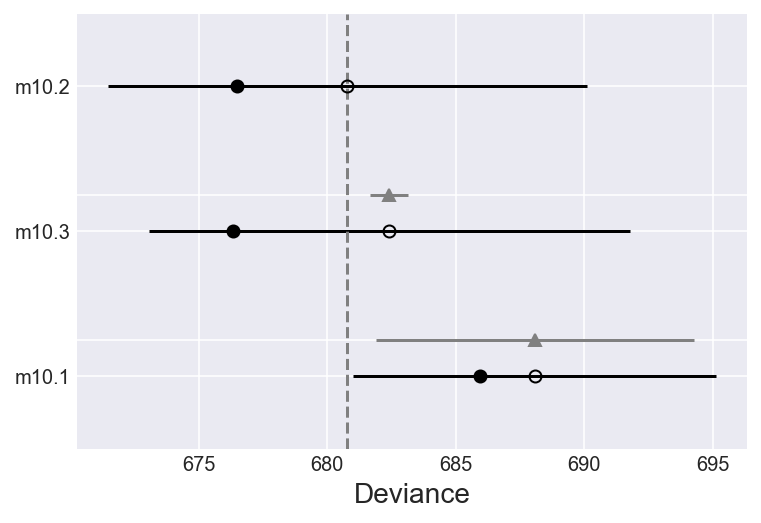

In [46]:
pm.compareplot(comp_df);

#### Code 10.6

In [47]:
pm.summary(trace_10_3, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.04,0.13,0.00,-0.15,0.26,1529.0,1.0
bp,0.61,0.23,0.01,0.23,0.95,1292.0,1.0
bpC,-0.10,0.26,0.01,-0.57,0.27,1107.0,1.0


#### Code 10.7

In [13]:
np.exp(0.61)

1.8404313987816374

#### Code 10.8

In [14]:
logistic(4)

0.98201379003790845

#### Code 10.9

In [15]:
logistic(4 + 0.61)

0.99014624447676869

#### Code 10.10 and 10.11

In [16]:
d_pred = pd.DataFrame({'prosoc_left' : [0, 1, 0, 1], 'condition' : [0, 0, 1, 1]})
traces = [trace_10_1, trace_10_2, trace_10_3]
models = [model_10_1, model_10_2, model_10_3]


chimp_ensemble = pm.sample_ppc_w(traces=traces, models=models, samples=1000, 
                                 weights=comp_df.weight.sort_index(ascending=True))

100%|██████████| 1000/1000 [00:05<00:00, 198.48it/s]


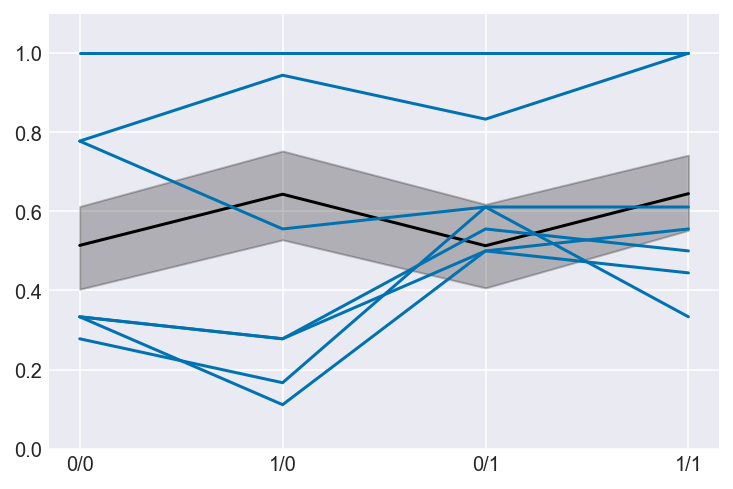

In [17]:
rt = chimp_ensemble['pulled_left']
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left==pl) & (d.chose_prosoc==cp)]))
    pred_mean[i] = tmp
    
ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
for i in range(7):
    plt.plot(chimps[i], 'C0')

plt.ylim(0, 1.1);

#### Code 10.12 & 10.13
This is the same as 10.6, but in the book using MCMC rather than quadratic approximation.

#### Code 10.14

In [18]:
with pm.Model() as model_10_4:
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 1993/2000 [00:06<00:00, 328.01it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 3 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2000/2000 [00:06<00:00, 302.80it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 9 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


#### Code 10.15

In [19]:
# remember we use a zero-index
d['actor'].unique()

array([0, 1, 2, 3, 4, 5, 6])

#### Code 10.16

In [20]:
pm.summary(trace_10_4, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha__0,-0.73,0.27,0.01,-1.18,-0.32,1654.0,1.0
alpha__1,10.95,5.13,0.17,3.39,17.98,657.0,1.0
alpha__2,-1.05,0.28,0.01,-1.50,-0.61,2000.0,1.0
alpha__3,-1.05,0.29,0.01,-1.53,-0.60,1611.0,1.0
alpha__4,-0.74,0.27,0.01,-1.20,-0.32,1549.0,1.0
alpha__5,0.22,0.27,0.01,-0.17,0.67,2000.0,1.0
alpha__6,1.81,0.39,0.01,1.15,2.38,1170.0,1.0
bp,0.83,0.27,0.01,0.40,1.25,1108.0,1.0
bpC,-0.13,0.29,0.01,-0.63,0.30,1567.0,1.0


#### Code 10.17

In [21]:
post = pm.trace_to_dataframe(trace_10_4)
post.head()

,bp,alpha__0,alpha__1,alpha__2,alpha__3,alpha__4,alpha__5,alpha__6,bpC
0,0.826948,-0.453805,6.798732,-1.321877,-1.410739,-0.900078,0.023299,1.801892,0.060304
1,0.971233,-0.313065,8.927043,-1.156584,-1.380544,-0.864947,-0.020430,1.743289,-0.154011
2,1.034632,-0.915841,10.353582,-1.064340,-1.048493,-0.488500,0.083710,1.920801,-0.620934
3,0.749830,-0.726021,13.272325,-1.160336,-1.210154,-1.215686,0.245273,1.476772,0.012503
4,0.671512,-0.895466,18.441973,-0.979079,-0.941614,-0.310818,0.162826,1.968357,-0.225672


#### Code 10.18

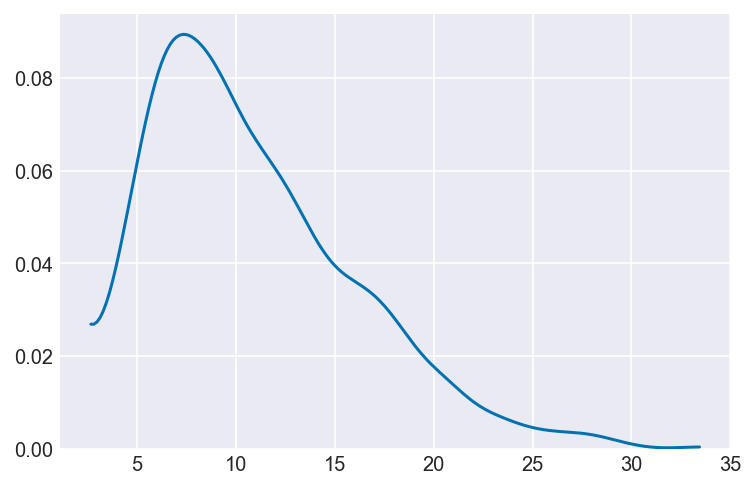

In [22]:
pm.kdeplot(post['alpha__1']);

#### Code 10.19

In [23]:
rt = pm.sample_ppc(trace_10_4, 1000, model_10_4)['pulled_left']

100%|██████████| 1000/1000 [00:01<00:00, 504.91it/s]


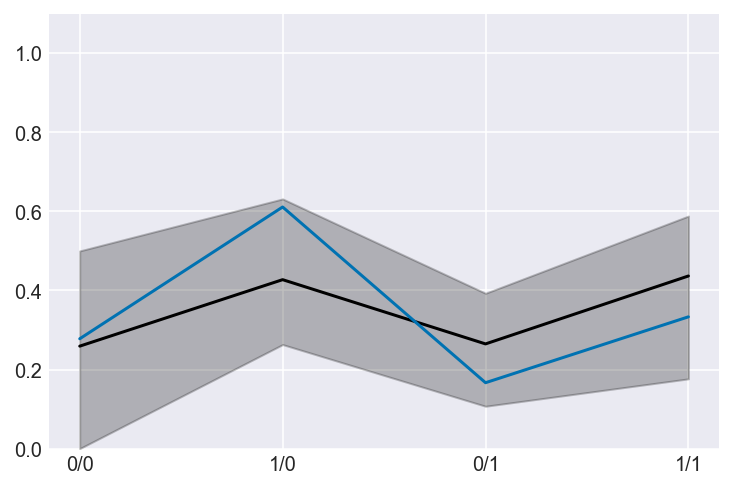

In [24]:
chimp = 2
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left == pl) & (d.chose_prosoc == cp) & (d.actor == chimp)]))
    pred_mean[i] = tmp

ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean, alpha=0.11)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d[d.actor == chimp].groupby(['condition', 'prosoc_left', ]).agg('mean')['pulled_left'].values
plt.plot(chimps, 'C0')

plt.ylim(0, 1.1);

#### Code 10.20

In [26]:
d_aggregated = d.groupby(['actor', 'condition', 'prosoc_left',  ])['pulled_left'].sum().reset_index()
d_aggregated.head(8)

,actor,condition,prosoc_left,pulled_left
0,0,0,0,6
1,0,0,1,9
2,0,1,0,5
3,0,1,1,10
4,1,0,0,18
5,1,0,1,18
6,1,1,0,18
7,1,1,1,18


#### Code 10.21

In [27]:
with pm.Model() as model_10_5:
    a = pm.Normal('alpha', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d_aggregated.condition) * d_aggregated.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_10_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:02<00:00, 716.58it/s]


In [29]:
pm.summary(trace_10_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.05,0.13,0.00,-0.20,0.28,1308.0,1.0
bp,0.62,0.22,0.01,0.21,1.10,1047.0,1.0
bpC,-0.11,0.26,0.01,-0.63,0.40,1179.0,1.0


In [30]:
# hacky check of similarity to 10_3, within a hundreth
np.isclose(pm.summary(trace_10_5), pm.summary(trace_10_3), atol=0.01)

array([[ True,  True,  True, False,  True, False,  True],
       [ True,  True,  True, False, False, False,  True],
       [False,  True,  True, False,  True, False,  True]], dtype=bool)

#### Code 10.22

In [31]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad.head(8)

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375


#### Code 10.23

In [32]:
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)

with pm.Model() as model_10_6:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a + bm * d_ad.male)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_6 = pm.sample(1000, tune=1000)
    
with pm.Model() as model_10_7:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 620.50it/s] 
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:01<00:00, 1351.90it/s]


#### Code 10.24

In [48]:
# Something goofy here... 
# not even close to WAIC values, larger standard error

comp_df = pm.compare([trace_10_6, trace_10_7], 
                     [model_10_6, model_10_7])

comp_df.loc[:,'model'] = pd.Series(['m10.6', 'm10.7'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
m10.6,996.19,114.68,0,0.39,313.66,0,1
m10.7,1046,80.1,49.81,0.61,313.93,155.23,1


#### Code 10.25

In [49]:
pm.summary(trace_10_6, alpha=.11).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-0.83,0.05,0.0,-0.93,-0.74,634.0,1.01
bm,0.61,0.06,0.0,0.49,0.73,600.0,1.01


#### Code 10.26

In [50]:
post = pm.trace_to_dataframe(trace_10_6)
p_admit_male = logistic(post['a'] + post['bm'])
p_admit_female = logistic(post['a'])
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[.025, .5, .975])[['2.5%', '50%', '97.5%']]

2.5%     0.114734
50%      0.142053
97.5%    0.169015
dtype: float64

#### Code 10.27

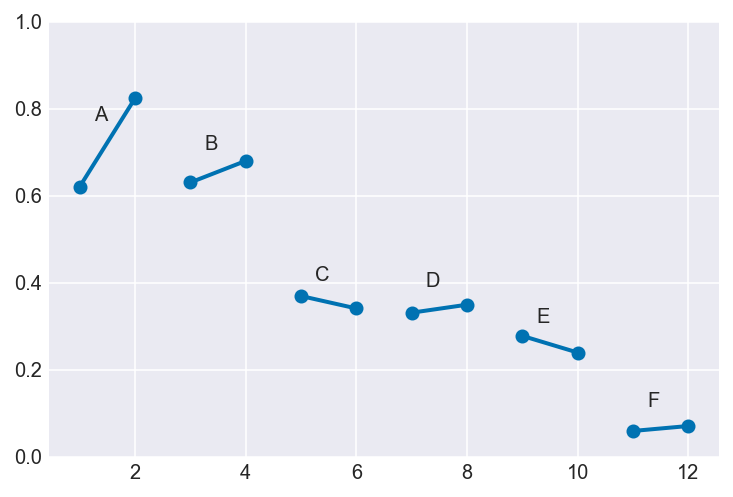

In [51]:
for i in range(6):
    x = 1 + 2 * i
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])
plt.ylim(0, 1);

#### Code 10.28

In [52]:
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

In [53]:
with pm.Model() as model_10_8:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    p = pm.math.invlogit(a[d_ad['dept_id'].values])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_8 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_9:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a[d_ad['dept_id'].values] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:02<00:00, 856.48it/s] 
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 564.23it/s]


#### Code 10.29

In [54]:
# WAIC values still off
# Plus warning flag

comp_df = pm.compare(traces=[trace_10_6, trace_10_7, trace_10_8, trace_10_9],
                     models=[model_10_6, model_10_7, model_10_8, model_10_9], 
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.6', 'm10.7', 'm10.8', 'm10.9'])
comp_df = comp_df.set_index('model')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
m10.8,105.79,6.92,0,0.83,17.45,0,1
m10.9,108.97,9.69,3.18,0.17,15.92,3.57,1
m10.6,996.19,114.68,890.4,0,313.66,310.51,1
m10.7,1046,80.1,940.21,0,313.93,311.44,1


#### Code 10.30

In [55]:
pm.summary(trace_10_9, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,0.68,0.10,0.0,0.52,0.84,855.0,1.0
a__1,0.64,0.11,0.0,0.47,0.84,1079.0,1.0
a__2,-0.58,0.07,0.0,-0.70,-0.46,2000.0,1.0
a__3,-0.62,0.09,0.0,-0.76,-0.48,1533.0,1.0
a__4,-1.06,0.10,0.0,-1.21,-0.90,2000.0,1.0
a__5,-2.64,0.16,0.0,-2.89,-2.38,2000.0,1.0
bm,-0.10,0.08,0.0,-0.23,0.03,673.0,1.0


#### Code 10.31
Replicated model above but with MCMC in book.

#### Code 10.32

In [78]:
import statsmodels.api as sm
from patsy import dmatrix

endog = d_ad.loc[:,['admit', 'reject']].values # cbind(admit,reject)

m10_7glm = sm.GLM(endog, dmatrix('~ 1', data=d_ad), 
                  family=sm.families.Binomial())
m10_6glm = sm.GLM(endog, dmatrix('~ male', data=d_ad), 
                  family=sm.families.Binomial())
m10_8glm = sm.GLM(endog, dmatrix('~ dept_id', data=d_ad), 
                  family=sm.families.Binomial())
m10_9glm = sm.GLM(endog, dmatrix('~ male + dept_id', data=d_ad), 
                  family=sm.families.Binomial())
# res = m10_7glm.fit()
# res.summary()

#### Code 10.33

In [94]:
import statsmodels.formula.api as smf
m10_4glm = smf.glm(formula='pulled_left ~ actor + prosoc_left*condition - condition', data=d, 
                   family=sm.families.Binomial())

#### Code 10.34

In [97]:
pm.GLM.from_formula('pulled_left ~ actor + prosoc_left*condition - condition', 
                    family='binomial', data=d)   

#### Code 10.35

In [100]:
# outcome and predictor almost perfectly associated
y = np.hstack([np.ones(10,)*0, np.ones(10,)])
x = np.hstack([np.ones(9,)*-1, np.ones(11,)])

m_bad = smf.glm(formula='y ~ x', 
                data=pd.DataFrame({'y':y, 'x':x}), 
                family=sm.families.Binomial()).fit()
m_bad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -3.3510
Date:                Sun, 05 Nov 2017   Deviance:                       6.7020
Time:                        17:12:43   Pearson chi2:                     11.0
No. Iterations:                    21                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1317   8032.690     -0.001      0.999   -1.58e+04    1.57e+04
x             12.4343   8032.690      0.002      0.999   -1.57e+04    1.58e+04
==============================================================================
"""

#### Code 10.36

In [101]:
with pm.Model() as m_good:
    ab = pm.Normal('ab', 0, 10, shape=2)
    p = pm.math.invlogit(ab[0] + ab[1]*x)
    y_ = pm.Binomial('y_', 1, p, observed=y)
    
    MAP = pm.find_MAP()
MAP

logp = -9.9185, ||grad|| = 7.2889e-05: 100%|██████████| 13/13 [00:00<00:00, 2092.08it/s]


{'ab': array([-1.72704484,  4.01710522])}

#### Code 10.37

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 584.35it/s]
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 16 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


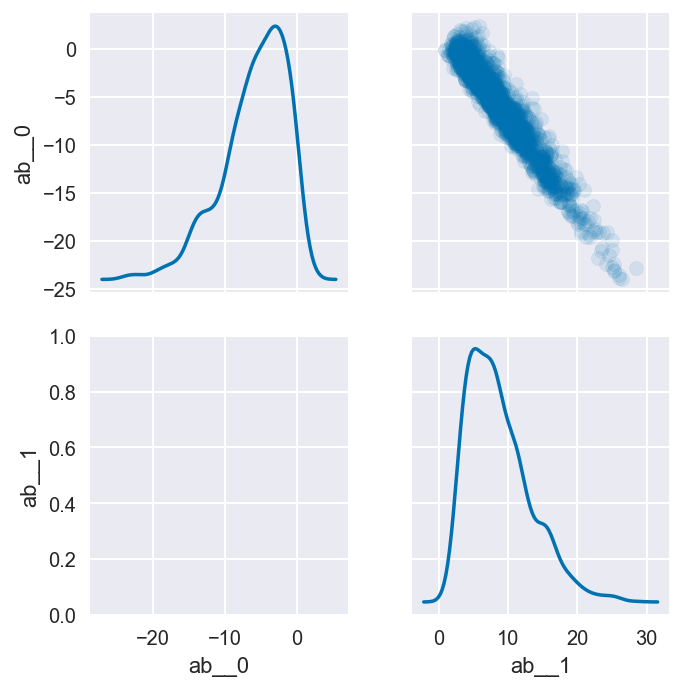

In [106]:
trace = pm.sample(1000, tune=1000, model=m_good)
tracedf = pm.trace_to_dataframe(trace)
grid = (sns.PairGrid(tracedf,
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1))

#### Code 10.38

In [107]:
y = stats.binom.rvs(n=1000, p=1/1000, size=100000)
np.mean(y), np.var(y)

(0.99697000000000002, 0.99812081909999983)

#### Code 10.39

In [108]:
dk = pd.read_csv('Data/Kline', sep=';')
dk

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


#### Code 10.40

In [109]:
dk.log_pop = np.log(dk.population)
dk.contact_high = (dk.contact == "high").astype(int)

#### Code 10.41

In [110]:
with pm.Model() as m_10_10:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * dk.log_pop + b[1] * dk.contact_high + b[2] * dk.contact_high * dk.log_pop)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:14<00:00, 139.89it/s]


#### Code 10.42

In [144]:
summary = pm.summary(trace_10_10, alpha=.11)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]
trace_cov = pm.trace_cov(trace_10_10, model=m_10_10)
invD = (np.sqrt(np.diag(trace_cov))**-1)[:, None]
trace_corr = pd.DataFrame(invD*trace_cov*invD.T, index=summary.index, columns=summary.index)

summary.join(trace_corr).round(2)

,mean,sd,hpd_5.5,hpd_94.5,a,b__0,b__1,b__2
a,0.93,0.34,0.37,1.42,1.00,-0.97,-0.16,0.10
b__0,0.26,0.03,0.21,0.31,-0.97,1.00,0.17,-0.13
b__1,-0.14,0.80,-1.35,1.20,-0.16,0.17,1.00,-0.99
b__2,0.05,0.09,-0.08,0.20,0.10,-0.13,-0.99,1.00


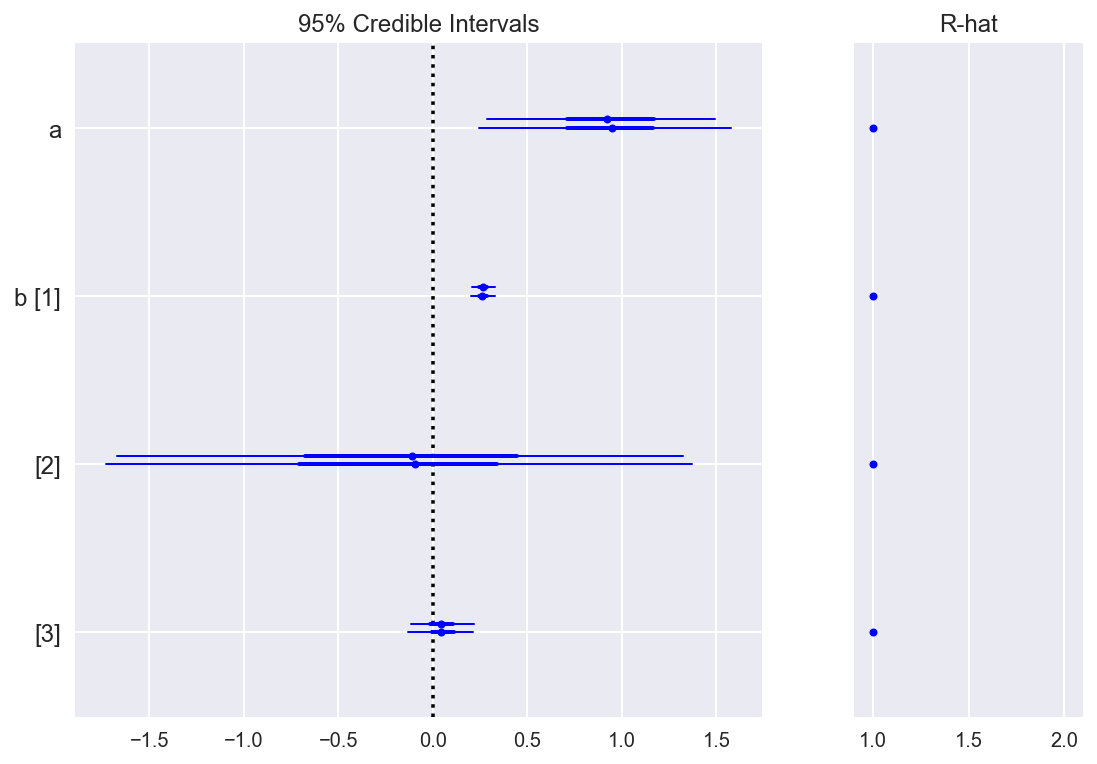

In [146]:
pm.forestplot(trace_10_10);

#### Code 10.43

In [147]:
lambda_high = np.exp(trace_10_10['a'] + trace_10_10['b'][:,1] + (trace_10_10['b'][:,0] + trace_10_10['b'][:,2]) * 8)
lambda_low = np.exp(trace_10_10['a'] + trace_10_10['b'][:,0] * 8 )

#### Code 10.44

In [148]:
diff = lambda_high - lambda_low
np.sum(diff > 0) / len(diff)

0.96050000000000002

#### Code 10.45

In [149]:
with pm.Model() as m_10_11:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=2)
    lam = pm.math.exp(a + b[0] * dk.log_pop + b[1] * dk.contact_high)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:07<00:00, 260.32it/s]


#### Code 10.46

In [150]:
with pm.Model() as m_10_12:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * dk.log_pop)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_12 = pm.sample(1000, tune=1000)
    
with pm.Model() as m_10_13:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * dk.contact_high)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 1982/2000 [00:04<00:00, 596.42it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.880093851093, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2000/2000 [00:04<00:00, 492.31it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:02<00:00, 953.28it/s] 




#### Code 10.47

In [151]:
with pm.Model() as m_10_14:
    a = pm.Normal('a', 0, 100)
    lam = pm.math.exp(a)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:01<00:00, 1761.22it/s]


In [152]:
traces = [trace_10_10, trace_10_11, trace_10_12, trace_10_13, trace_10_14]
models = [m_10_10, m_10_11, m_10_12, m_10_13, m_10_14]

islands_compare = pm.compare(traces, models, method='pseudo-BMA')

islands_compare.loc[:,'model'] = pd.Series(['m10.10', 'm10.11', 'm10.12', 'm10.13', 'm10.14'])
islands_compare = islands_compare.set_index('model')
islands_compare

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
model,,,,,,,
m10.11,78.97,4.22,0,0.56,11.18,0,1
m10.10,79.66,4.68,0.7,0.4,11.3,1.33,1
m10.12,84.39,3.72,5.42,0.04,8.91,8.01,1
m10.14,140.71,7.79,61.74,0,31.18,32.36,1
m10.13,150.3,16.75,71.33,0,45.04,44.77,1


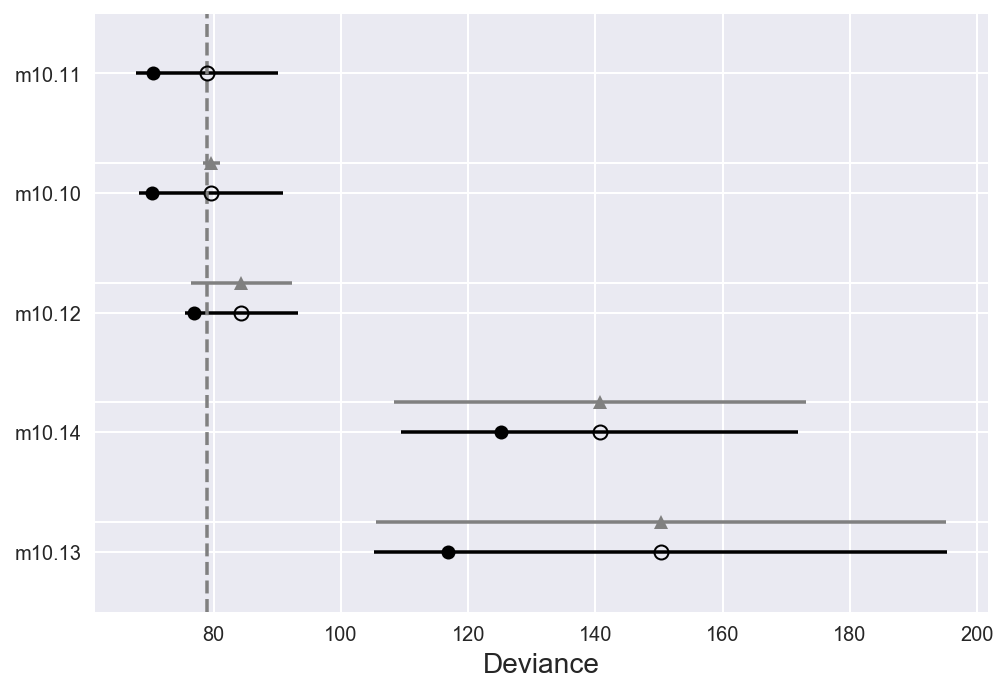

In [153]:
pm.compareplot(islands_compare);

#### Code 10.48

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

In [50]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.1
Pandas 0.20.3
SciPy 0.19.1
Matplotlib 2.0.2

